# SUN RADIATION – NEURAL ODE

In [2]:
import sys
# !{sys.executable} -m pip list | grep lightning
!{sys.executable} -m pip list | grep torch

pytorch-lightning         1.9.5
torch                     1.13.1
torchcde                  0.2.5
torchdiffeq               0.2.3
torchdyn                  1.0.4
torchmetrics              0.11.4
torchsde                  0.2.5


In [6]:
import torch
print(torch.__version__)

1.13.1+cu117


In [11]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *
import rich
from pytorch_lightning.callbacks import RichProgressBar


%load_ext autoreload
%autoreload 2

Extension horovod.torch has not been built: /home/user/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [15]:
import numpy as np
from tqdm import tqdm
files = !ls data
XYdata = {}
for file in files:
    XYdata[file.split('.')[0]] = np.load('data/'+file) 
    print(XYdata[file.split('.')[0]].shape, file)

(135680, 137) ccl4_vmr.npy
(135680, 137) cfc11_vmr.npy
(135680, 137) cfc12_vmr.npy
(135680, 137) ch4_vmr.npy
(135680, 137) cloud_fraction.npy
(135680, 137) co2_vmr.npy
(135680,) cos_solar_zenith_angle.npy
(135680, 138) flux_dn_lw.npy
(135680, 138) flux_dn_sw.npy
(135680, 138) flux_up_lw.npy
(135680, 138) flux_up_sw.npy
(135680, 137) fractional_std.npy
(135680, 137) hcfc22_vmr.npy
(135680, 137) hr_lw.npy
(135680, 137) hr_sw.npy
(135680, 137) inv_cloud_effective_size.npy
(135680,) lat.npy
(135680,) lon.npy
(135680, 2) lw_emissivity.npy
(135680, 137) n2o_vmr.npy
(135680, 137) o2_vmr.npy
(135680, 137) o3_mmr.npy
(135680, 136) overlap_param.npy
(135680, 138) pressure_hl.npy
(135680, 137) q.npy
(135680, 137) q_ice.npy
(135680, 137) q_liquid.npy
(135680, 137) re_ice.npy
(135680, 137) re_liquid.npy
(135680,) skin_temperature.npy
(135680,) solar_irradiance.npy
(135680, 6) sw_albedo.npy
(135680, 6) sw_albedo_direct.npy
(135680, 138) temperature_hl.npy


**Data:** we use again the moons dataset (with some added noise) simply because all the models will be effective to solve this easy binary classification problem.



In [58]:
not_cloudy_ids = [i for i in range(135680) if max(XYdata['cloud_fraction'][i]) < 0.001]
len(not_cloudy_ids)

5833

In [64]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(not_cloudy_ids, test_size=0.02, random_state=108)
len(train_ids), len(test_ids)

(5716, 117)

In [16]:
h_max = 138

In [17]:
def prepareXY(i):
    _X = []
    _yn = []
    for l in range(h_max-1):
        _X.append([l,
                   XYdata['skin_temperature'][i],
                   XYdata['o3_mmr'][i][l],
                   XYdata['cloud_fraction'][i][l],
                   XYdata['re_ice'][i][l],                   
                   XYdata['re_liquid'][i][l],
                   XYdata['q_ice'][i][l],
                   XYdata['q_liquid'][i][l],
                   (XYdata['temperature_hl'][i][l] + XYdata['temperature_hl'][i][l+1]) / 2.                   
#                    XYdata['aerosol_mmr'][i][0][l],
#                    XYdata['aerosol_mmr'][i][1][l],
#                    XYdata['aerosol_mmr'][i][2][l],
#                    XYdata['aerosol_mmr'][i][3][l],
#                    XYdata['aerosol_mmr'][i][4][l],
#                    XYdata['aerosol_mmr'][i][5][l],
#                    XYdata['aerosol_mmr'][i][6][l],
#                    XYdata['aerosol_mmr'][i][7][l],
#                    XYdata['aerosol_mmr'][i][8][l],
#                    XYdata['aerosol_mmr'][i][9][l],
#                    XYdata['aerosol_mmr'][i][10][l],
#                    XYdata['aerosol_mmr'][i][11][l],               
                   ])
        _yn.append(( XYdata['flux_up_lw'][i][l] + XYdata['flux_up_lw'][i][l+1]) / 2. )  
    return _X, _yn

In [65]:
X = []
yn = []
for i in train_ids:
    _X, _yn = prepareXY(i)
    X.extend(_X)
    yn.extend(_yn)

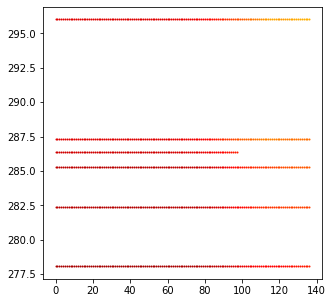

In [73]:
import matplotlib as mpl
import matplotlib.cm as cm
norm = mpl.colors.Normalize(vmin=min(yn), vmax=max(yn))
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(len(X)//1000):
    ax.scatter(X[i][0], X[i][1], s=1, color=m.to_rgba(yn[i]))

In [74]:
import torch
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

X_train = torch.Tensor(X).to(device)
y_train = torch.Tensor(yn).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

cuda:0


In [75]:
X_train.shape, y_train.shape

(torch.Size([783092, 9]), torch.Size([783092]))

In [76]:
# quick run for automated notebook validation
dry_run = False

**Learner**

In [77]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory

#         print('y',y.shape, y)
#         print('y_hat',y_hat.shape, y_hat)
#         loss = nn.MSELoss()(y_hat, y)

        loss = nn.MSELoss(reduction='none')
        loss_result = torch.sum(loss(y_hat[:,0],y),dim=0)
    
        return {'loss': loss_result}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

**Note:** In this notebook we will consider the depth domain $[0,1]$, i.e. $t\in[0,1]$. Note that, for most architectures in *static* settings (aka we do not deal with dynamic data) any other depth domain does not actually affect the expressiveness of Neural ODEs, since it can be seen as a rescaled/shifted version of $[0,1]$. Please note that, however, other choices of the depth domain can indeed affect the training phase

The depth domain can be accessed and modified through the `t_span` setting of `NeuralODE` instances.

## Vanilla Neural ODE (Depth-Invariant)

$$ \left\{
    \begin{aligned}
        \dot{z}(t) &= f(z(t), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad t\in[0,1]
$$

This model is the same used in [torchdyn quickstart](./00_quickstart.html) tutorial. The vector field is parametrized by a neural network $f$ with *static* parameters $\theta$ and taking as input only the state $h(s)$.

In [78]:
t_span = torch.linspace(0, 1, 10)
t_span

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [79]:
dim = X_train.shape[1]
print('dim', dim)

dim 9


In [80]:
# vector field parametrized by a NN
f = nn.Sequential(
        nn.Linear(dim, 64),
        nn.Tanh(), 
        nn.Linear(64, dim))

# Neural ODE
# `interpolator` here refers to the scheme used together with `solver` to ensure estimates of the solution at all points in `t_span` are returned. 
# During solution of the adjoint, cubic interpolation is used regardless of `interpolator`.
model = NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-3, rtol=1e-3).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [82]:
# train the Neural ODE
learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=2500, accelerator='gpu', devices=1)
# else: trainer = pl.Trainer(min_epochs=200, max_epochs=250)
trainer.fit(learn)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 1.2 K 
------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

`Trainer.fit` stopped: `max_epochs=2500` reached.


**Plots**

In [99]:
X_test, y_test =  prepareXY(test_ids[10])

In [100]:
X_test = torch.tensor(X_test).float().cpu()
y_test = torch.tensor(y_test).float().cpu()

t_eval, trajectory = model(X_test, t_span)
trajectory = trajectory.detach()
t_eval = t_eval.detach()
y_pred = trajectory[-1, :, 0]

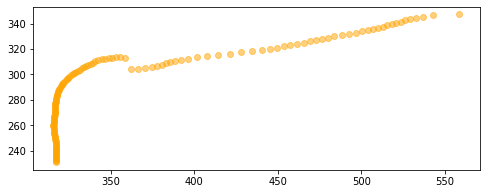

In [101]:
# epochs=2500
# f = nn.Sequential(
#         nn.Linear(dim, 64),
#         nn.Tanh(), 
#         nn.Linear(64, dim))

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.scatter(y_test, y_pred, color='orange',alpha=0.5)

In [102]:
loss = nn.MSELoss(reduction='none')
loss_result = torch.mean(loss(y_test, y_pred),dim=0)
print(float(loss_result))

8553.8388671875


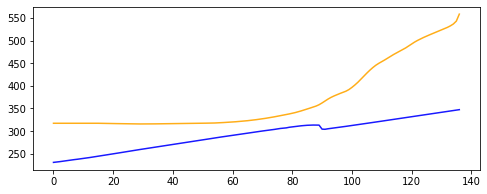

In [103]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot(X_test[:,0], y_pred, color='blue', alpha=.9)
ax.plot(X_test[:,0], y_test, color='orange', alpha=.9)